# Packages and Libraries

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Dataset

In [15]:
import cv2
import imghdr
import pathlib # For path 
import os

In [16]:
image_exts = ['jpeg','jpg', 'bmp', 'png']
data_dir = 'data'

## Remove unusable data

In [17]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data\Adobo\.ipynb_checkpoints
Issue with image data\Sinigang\.ipynb_checkpoints


In [18]:
data_dir = pathlib.Path(data_dir)

In [19]:
image_count = len(list(data_dir.glob('*/*.*')))
print(f"Total number of images: {image_count}")

Total number of images: 1925


## Create dataset

In [20]:
batch_size = 32
img_height = 180
img_width = 180

Training Dataset

In [43]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1926 files belonging to 2 classes.
Using 1541 files for training.


Validation Dataset

In [41]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1926 files belonging to 2 classes.
Using 385 files for validation.


Print Class

In [23]:
class_names = train_ds.class_names
print(class_names)

['Adobo', 'Sinigang']


## Data Visualization

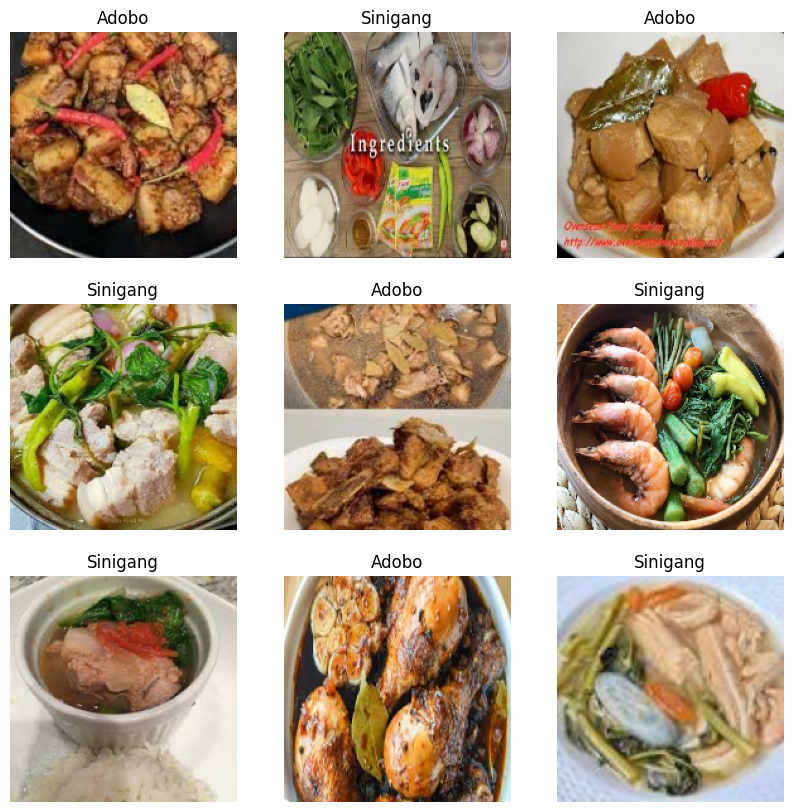

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Batch information

In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure and Standardize the Dataset

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model

## Create the Model

In [29]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the Model

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training the Model

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
72/72 [==============================] - 41s 567ms/step - loss: 1.0054 - accuracy: 0.5363 - val_loss: 0.8095 - val_accuracy: 0.6557
Epoch 2/10
72/72 [==============================] - 39s 544ms/step - loss: 0.6419 - accuracy: 0.7466 - val_loss: 0.5807 - val_accuracy: 0.7496
Epoch 3/10
72/72 [==============================] - 39s 547ms/step - loss: 0.4739 - accuracy: 0.8209 - val_loss: 0.5015 - val_accuracy: 0.8000
Epoch 4/10
72/72 [==============================] - 41s 574ms/step - loss: 0.3549 - accuracy: 0.8688 - val_loss: 0.6438 - val_accuracy: 0.7948
Epoch 5/10
72/72 [==============================] - 40s 550ms/step - loss: 0.2685 - accuracy: 0.9053 - val_loss: 0.7835 - val_accuracy: 0.7183
Epoch 6/10
72/72 [==============================] - 37s 518ms/step - loss: 0.1735 - accuracy: 0.9426 - val_loss: 0.4670 - val_accuracy: 0.8539
Epoch 7/10
72/72 [==============================] - 40s 551ms/step - loss: 0.0999 - accuracy: 0.9678 - val_loss: 0.5803 - val_accuracy: 0.8539

Text(0.5, 1.0, 'Training and Validation Accuracy')

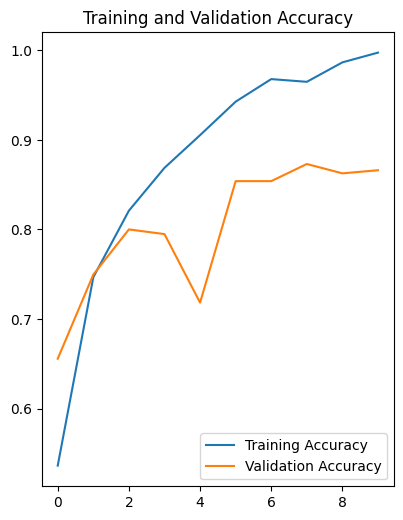

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5.9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

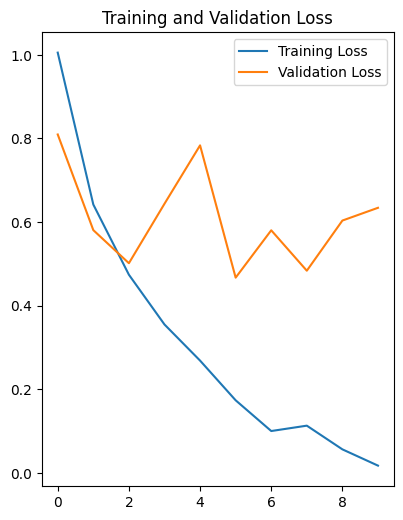

In [23]:
plt.figure(figsize=(10, 5.9))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
import cv2

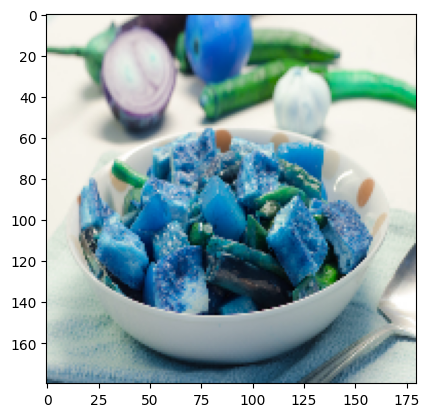

In [26]:
img = cv2.imread('pinakbet.jpg')

resize = tf.image.resize(img, (180,180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [27]:
predictions = model.predict(np.expand_dims(resize/255, 0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 857ms/step
This image most likely belongs to Adobo with a 99.58 percent confidence.


## Regularization (Prevent Overfitting)

### Data Augmentation

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

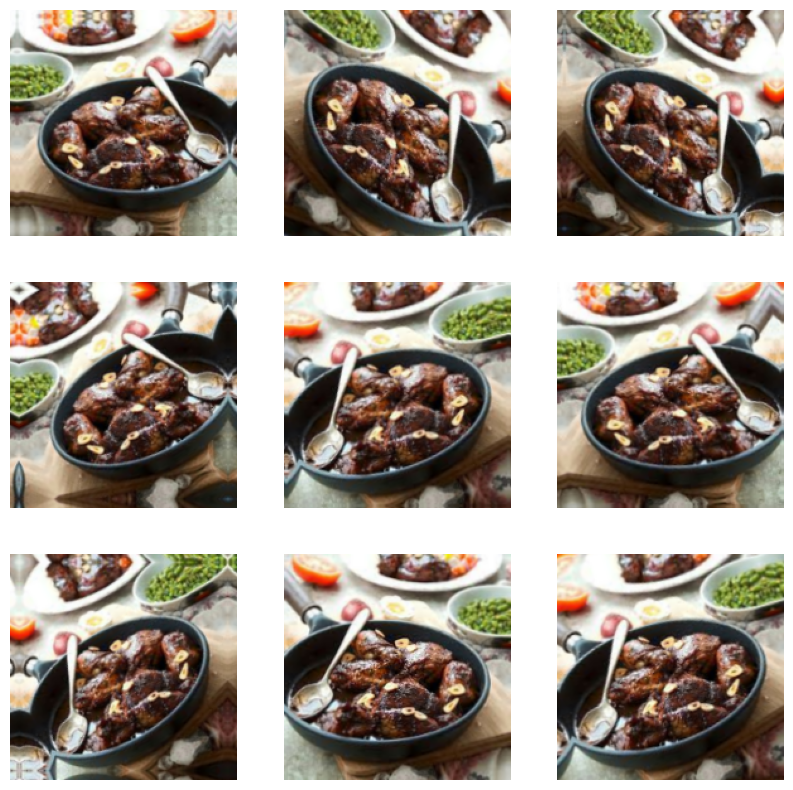

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [32]:
model = Sequential([
  data_augmentation,
    
  layers.Rescaling(1./255),
    
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.2),
    
  layers.Flatten(),
  layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
    
  layers.Dense(num_classes, name="outputs")
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)       

In [35]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
49/49 [==============================] - 55s 1s/step - loss: 0.4186 - accuracy: 0.8709 - val_loss: 2.2630 - val_accuracy: 0.5013
Epoch 2/15
49/49 [==============================] - 40s 814ms/step - loss: 0.1909 - accuracy: 0.9202 - val_loss: 0.6176 - val_accuracy: 0.7636
Epoch 3/15
49/49 [==============================] - 41s 842ms/step - loss: 0.1481 - accuracy: 0.9481 - val_loss: 0.4894 - val_accuracy: 0.7896
Epoch 4/15
49/49 [==============================] - 46s 952ms/step - loss: 0.1210 - accuracy: 0.9500 - val_loss: 0.4314 - val_accuracy: 0.8494
Epoch 5/15
49/49 [==============================] - 42s 863ms/step - loss: 0.1115 - accuracy: 0.9585 - val_loss: 0.2453 - val_accuracy: 0.9013
Epoch 6/15
49/49 [==============================] - 46s 944ms/step - loss: 0.0701 - accuracy: 0.9773 - val_loss: 0.2226 - val_accuracy: 0.9117
Epoch 7/15
49/49 [==============================] - 46s 933ms/step - loss: 0.0673 - accuracy: 0.9760 - val_loss: 0.2085 - val_accuracy: 0.8987
Ep

Text(0.5, 1.0, 'Training and Validation Accuracy')

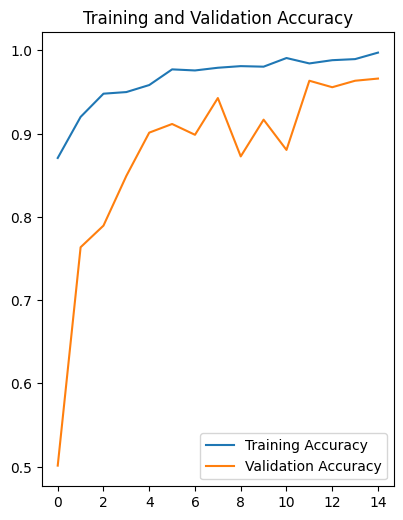

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5.9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



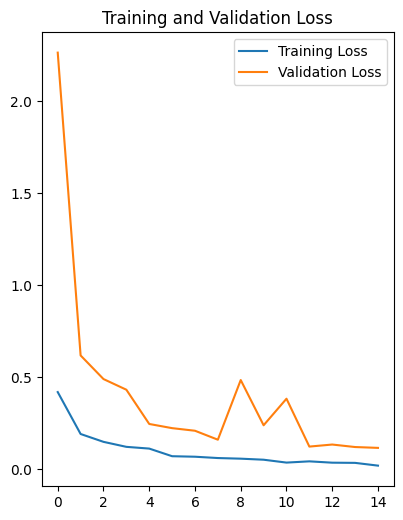

In [37]:
plt.figure(figsize=(10, 5.9))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

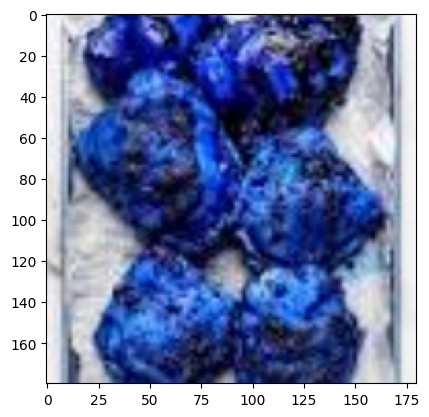

In [38]:
import cv2
img = cv2.imread('data/Adobo/Adobo_101.jpg')

resize = tf.image.resize(img, (180, 180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
predictions = model.predict(np.expand_dims(resize/180, 0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(score)

1/1 [==============================] - 0s 153ms/step
This image most likely belongs to Adobo with a 57.02 percent confidence.
tf.Tensor([0.5701714  0.42982864], shape=(2,), dtype=float32)


13/13 [==============================] - 3s 148ms/step
there were 216 correct predictions in 385 tests for an accuracy of  56.10 % 


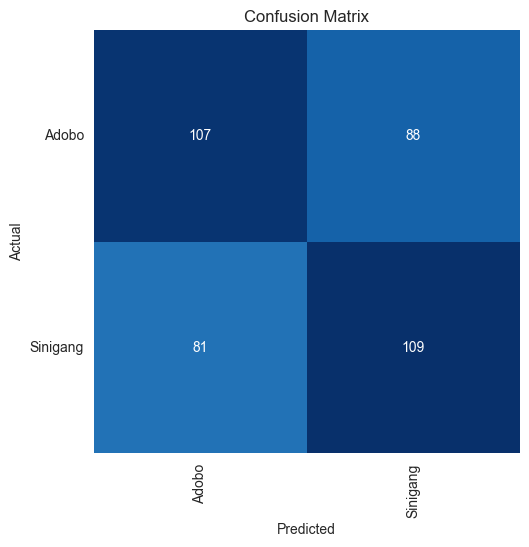

Classification Report:
----------------------
               precision    recall  f1-score   support

       Adobo       0.57      0.55      0.56       195
    Sinigang       0.55      0.57      0.56       190

    accuracy                           0.56       385
   macro avg       0.56      0.56      0.56       385
weighted avg       0.56      0.56      0.56       385



In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
classes=val_ds.class_names # ordered list of class names
ytrue=[]
for images, label in val_ds:   
    for e in label:
        ytrue.append(classes[e]) # list of class names associated with each image file in test dataset 
        
ypred=[]
errors=0
count=0
preds=model.predict(val_ds, verbose=1) # predict on the test data
for i, p in enumerate(preds):
    count +=1
    index=np.argmax(p) # get index of prediction with highest probability
    klass=classes[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1
acc= (count-errors)* 100/count
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
print(msg) 
ypred=np.array(ypred)
ytrue=np.array(ytrue)
if len(classes)<= 30: # if more than 30 classes plot is not useful to cramed
        # create a confusion matrix 
        cm = confusion_matrix(ytrue, ypred )        
        length=len(classes)
        if length<8:
            fig_width=5.5
            fig_height=5.5
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
clr = classification_report(ytrue, ypred, target_names=class_names)
print("Classification Report:\n----------------------\n", clr) 